In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

In [2]:
all_AVA_muts = pd.read_pickle("../data/ava/4_10_with_uniq_midpts.pkl")
display(len(all_AVA_muts), all_AVA_muts.head())

5676

,index,exp,ale,flask,isolate,tech_rep,presence,Position,Mutation Type,Sequence Change,Details,mutation target annotation,Reference Seq,sample,coding,range,gene RegulonDB ID,genetic features,oriC,pseudogene,TFBS,promoter,RBS,attenuator terminator,terminator,genetic,genomic features,genetic feature links,operons,operon links,regulators,regulator links,pathways,pathway links,COGs,COG links,imodulons,imodulon links,EC numbers,EC number links,products,product links,temperature,carbon-source,supplement,strain-description,taxonomy-id,base-media,nitrogen-source,phosphorous-source,sulfur-source,calcium-source
0,9,42C,1,124,1,1,1.0,702352,DEL,Δ21 bp,coding (380‑400/1149 nt),nagA,NaN,1 124 1 1,True,"(702352, 702372)",{ECK120000625},"[{'name': 'nagA', 'RegulonDB ID': 'ECK12000062...",False,False,{},{},{},{},{},True,"[{'name': 'nagA', 'RegulonDB ID': 'ECK12000062...",{'ECK120000625': ['ECK120000625']},"[{'name': 'nagBAC-umpH', 'RegulonDB ID': 'ECK1...",{'ECK125162049': ['ECK120000625']},"[{'name': 'PhoP', 'significantly associated co...","{'NagC': ['ECK125162049'], 'PhoP': ['ECK125162...","[{'name': 'Galactose metabolism', 'significant...","{'Galactose metabolism': ['ECK125162049'], 'Am...",[{'name': 'Carbohydrate transport and metaboli...,{'Carbohydrate transport and metabolism': ['EC...,"[{'name': 'NagC/TyrR', 'significantly associat...",{'NagC/TyrR': ['nagBAC-umpH']},"[{'name': '3.5.1.25', 'significantly associate...","{'3.5.1.25': ['ECK125162049', 'ECK125162049']}",[{'name': 'N-acetylglucosamine-6-phosphate dea...,{'N-acetylglucosamine-6-phosphate deacetylase ...,42 celsius,glucose(4),NaCl(0.5g/L) trace elements,WT,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)
1,10,42C,1,124,1,1,1.0,1308318,SNP,G→C,R110G (CGT→GGT),clsA,NaN,1 124 1 1,True,"(1308318, 1308318)",{ECK120001556},"[{'name': 'clsA', 'RegulonDB ID': 'ECK12000155...",False,False,{},{},{},{},{},True,"[{'name': 'clsA', 'RegulonDB ID': 'ECK12000155...",{'ECK120001556': ['ECK120001556']},"[{'name': 'clsA-yciU', 'RegulonDB ID': 'ECK125...",{'ECK125147415': ['ECK120001556']},[],{},[],{},[{'name': 'Lipid transport and metabolism'}],{'Lipid transport and metabolism': ['ECK125147...,[],{},[],{},[],{},42 celsius,glucose(4),NaCl(0.5g/L) trace elements,WT,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)
2,11,42C,1,124,1,1,1.0,3815859,DEL,Δ82 bp,None,rph,NaN,1 124 1 1,True,"(3815859, 3815940)",{ECK120000854},"[{'name': 'rph', 'RegulonDB ID': 'ECK120000854...",False,False,{},{},{},{ECK125144791},{},True,"[{'name': 'rph-pyrE attenuator terminator', 'R...","{'ECK120000854': ['ECK120000854'], 'ECK1200007...","[{'name': 'rph-pyrE', 'RegulonDB ID': 'ECK1200...","{'ECK120014627': ['ECK120000854', 'ECK12000079...",[],{},"[{'name': 'Pyrimidine metabolism', 'significan...","{'Pyrimidine metabolism': ['ECK120014627'], 'D...",[{'name': 'Nucleotide transport and metabolism'}],{'Nucleotide transport and metabolism': ['ECK1...,"[{'name': 'purR-KO', 'significantly associated...","{'purR-KO': ['rph-pyrE', 'rph-pyrE']}","[{'name': '2.4.2.10', 'significantly associate...","{'2.4.2.10': ['ECK120014627', 'ECK120014627']}",[{'name': 'Orotate phosphoribosyltransferase (...,{'Orotate phosphoribosyltransferase (EC 2.4.2....,42 celsius,glucose(4),NaCl(0.5g/L) trace elements,WT,511145,M9,NH4Cl(1),KH2PO4(3) Na2HPO4(6.8),MgSO4(0.24),CaCl2(0.1)
3,12,42C,1,124,1,1,1.0,4187550,SNP,C→T,A734V (GCG→GTG),rpoC,NaN,1 124 1 1,True,"(4187550, 4187550)",{ECK120000886},"[{'name': 'rpoC', 'RegulonDB ID': 'ECK12000088...",False,False,{},{},{},{},{},True,"[{'name': 'rpoC', 'RegulonDB ID': 'ECK12000088...",{'ECK120000886': ['ECK120000886']},"[{'name': 'rplKAJL-rpoBC', 'RegulonDB ID': 'EC...",{'ECK120016992': ['ECK120000886']},[],{},"[{'name': 'Purine metabolism', 'significantly ...","{'Purine metabolism': ['ECK120016992'], 'Pyrim...",[{'name': 'Transcription'}],{'Transcription': ['ECK120016992']},"[{'name': 'translation', 'significantly associ...",{'translation': ['rplKAJL-rpoBC']},"[{'name': '2.7.7.6'

In [5]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from mutil.mut import get_mut_size

# disregarding all deletions of size > 1000 bp (about the size of a gene) since these mutations don't contribute to design and only inflate mutation counts to systems leading to false positives.
all_AVA_muts["mutation size"] = all_AVA_muts.apply(get_mut_size, axis=1)
all_AVA_muts = all_AVA_muts[~((all_AVA_muts["Mutation Type"]=="DEL") & (all_AVA_muts["mutation size"]>1000))].copy()
len(all_AVA_muts)

5617

In [6]:
all_AVA_muts["exp ale"] = all_AVA_muts.apply(lambda m: m["exp"] + ' ' + str(int(m["ale"])), axis=1)

In [7]:
FEATURE_TYPES = [
    "genomic features",
    "operons",
    "pathways",
#     "imodulons",
    "regulators",
#     "EC numbers",
#     "products"
]

In [8]:
def get_expanded_feat_type(given_feat_type, feat_d):
    ft = given_feat_type
    if ft == "genomic features":
        ft = feat_d["feature type"]
        if ft == "unknown":
            ft = "intergenic" 
    return ft

In [9]:
# preprocessing
# feat_pen_d = {ft:dict() for ft in FEATURE_TYPES}
feat_pen_d = {}
for _, m in all_AVA_muts.iterrows():
    for ft in FEATURE_TYPES:
        for f in m[ft]:
            
            out_ft = get_expanded_feat_type(ft, f)
            if out_ft not in feat_pen_d.keys():  # Since feat_pen_d is empty by default, need to add first dict layer before adding 2nd layer for specific feature
                    feat_pen_d[out_ft] = {}
            
            if (str(f["name"]) != "nan") & (f["name"] not in feat_pen_d[out_ft].keys()):
                feat_pen_d[out_ft][f["name"]] = []
feat_pen_d.keys()

dict_keys(['gene', 'operons', 'pathways', 'regulators', 'attenuator terminator', 'intergenic', 'promoter', 'terminator', 'TFBS', 'RBS'])

In [10]:
for exp, exp_mut_df in all_AVA_muts.groupby("exp"):
    
#     exp_feat_ale_d = {ft:dict() for ft in FEATURE_TYPES}
    exp_feat_ale_d = dict()
    for _, m in exp_mut_df.iterrows():
        
        for ft in FEATURE_TYPES:  # must use regular feature types since the mutation rows don't differentiate between sub "genomic feature" types (gene, TFBS, etc)
            for f in m[ft]:
                
                updt_ft = get_expanded_feat_type(ft, f)
                if updt_ft not in exp_feat_ale_d.keys():  # Since feat_pen_d is empty by default, need to add first dict layer before adding 2nd layer for specific feature
                    exp_feat_ale_d[updt_ft] = {}
                
                if str(f["name"]) != "nan":
                    if f["name"] not in exp_feat_ale_d[updt_ft].keys():
                        exp_feat_ale_d[updt_ft][f["name"]] = set()
                    exp_feat_ale_d[updt_ft][f["name"]].add(m["exp ale"])          
#     display(exp_feat_ale_d)
    
    for updt_ft in exp_feat_ale_d.keys():
        for f, feat_exp_ales in exp_feat_ale_d[updt_ft].items():
            feat_exp_pen = len(feat_exp_ales) / len(exp_mut_df["exp ale"].unique())
            if feat_exp_pen > 0:
                feat_pen_d[updt_ft][f].append(feat_exp_pen)

# testing to make sure that all individual features are getting penetrance values
for ft, fd in feat_pen_d.items():
    for fn, pens in fd.items():
        assert(len(pens) > 0)                

# feat_pen_d

In [11]:
feat_avg_pen_d = {ft:dict() for ft in feat_pen_d.keys()}
for ft in feat_pen_d.keys():
    for f, pens in feat_pen_d[ft].items():
        feat_avg_pen_d[ft][f] = sum(pens) / len(pens)
# feat_avg_pen_d

In [12]:
mat = pd.DataFrame()
for _, m in all_AVA_muts.iterrows():
    for ft in FEATURE_TYPES:
        links_already_counted_for = set()
        for f in m[ft]:  # must use regular feature types since the mutation rows don't differentiate between sub "genomic feature" types (gene, TFBS, etc)
            if str(f["name"]) != "nan":  # !!! only counting features with names. This could lead to slightly inaccurate results.
                
                mat_index = str(f["name"])
                updt_ft = get_expanded_feat_type(ft, f)
                if ft != "genomic features":
                    mat_index = mat_index + ' ' + updt_ft[:-1]
                
                if mat_index not in mat.index:
                    avg_pen = feat_avg_pen_d[updt_ft][f["name"]]
                    srs = pd.Series({
                        "feature type": updt_ft,
                        "average ALE experiment convergence": avg_pen,  # only needs to be recorded once
                        "ALE-unique mutation count": 0})  # setting up for later cells to populate
                    srs.name = mat_index
                    mat = mat.append(srs)
                
                if ft == "genomic features":
                    mat.at[mat_index, "ALE-unique mutation count"] += 1 # add count every time come across feature type
                else:  # have to count their links, not simply the occurence.
                    if f['name'] not in links_already_counted_for:  # so as to not double-count feature links
                        links_already_counted_for.add(f['name'])
                        links_col = ft[:-1] + " links"
                        link_key = f['name']
                        if ft == "operons":
                            link_key = f['RegulonDB ID']

                        try:
                            mat.at[mat_index, "ALE-unique mutation count"] += len(m[links_col][link_key]) # add count every time come across feature type
                        except:
                            display(link_key, m[ft], m[links_col])
                        
mat.index = mat.apply(lambda r: str(r.name).replace("regulator", "regulon") if r["feature type"] == "regulators" else r.name, axis=1)  # some products have "regulator" in their name
mat['ALE-unique mutation count'] = mat['ALE-unique mutation count'].astype(int)
mat

'ECK120014729'

[{'name': 'gltBDF',
  'RegulonDB ID': 'ECK120014729',
  'range': (3354148, 3361940),
  'significantly associated conditions': set()}]

{}

'FNR'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'Nac'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'AdiY'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'Fur'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'HdfR'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'CRP'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'Lrp'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'GadE'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'ArgR'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

'IHF'

[{'name': 'FNR', 'significantly associated conditions': set()},
 {'name': 'Nac',
  'significantly associated conditions': {'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements'}},
 {'name': 'AdiY',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'Fur', 'significantly associated conditions': {'P. aerophilum pgi'}},
 {'name': 'HdfR', 'significantly associated conditions': set()},
 {'name': 'CRP', 'significantly associated conditions': set()},
 {'name': 'Lrp', 'significantly associated conditions': {'NH4Cl(1)'}},
 {'name': 'GadE',
  'significantly associated conditions': {'CaCl2(0.1)',
   'KH2PO4(3) Na2HPO4(6.8)',
   'M9',
   'MgSO4(0.24)',
   'NH4Cl(1)',
   'NaCl(0.5g/L) trace elements',
   'glucose(4)'}},
 {'name': 'ArgR', 'significantly associated conditions': set()},
 {'name': 'IHF', 'significantly associated conditions': set()}]

{}

,ALE-unique mutation count,average ALE experiment convergence,feature type
nagA,10,0.243452,gene
nagBAC-umpH operon,36,0.372348,operons
Galactose metabolism pathway,79,0.423115,pathways
Amino sugar and nucleotide sugar metabolism pathway,73,0.396440,pathways
PhoP regulon,66,0.321222,regulators
...,...,...,...
ydiK,1,0.500000,gene
ydiK operon,1,0.500000,operons
csrA,1,0.500000,gene
csrA operon,1,0.500000,operons


In [13]:
def _rename_feats(f):
    o = f
    
    if f == "regulators":
        o = "regulon"
    if f == "EC numbers":
        o = "reaction"
        
    if o[-1] == 's':
        o = o[:-1]
        
    return o

mat["feature type"] = mat.apply(lambda x: _rename_feats(x["feature type"]), axis=1)
mat["feature type"].unique()

array(['gene', 'operon', 'pathway', 'regulon', 'attenuator terminator',
       'intergenic', 'promoter', 'terminator', 'TFBS', 'RBS'],
      dtype=object)

(0.0, 1.1)

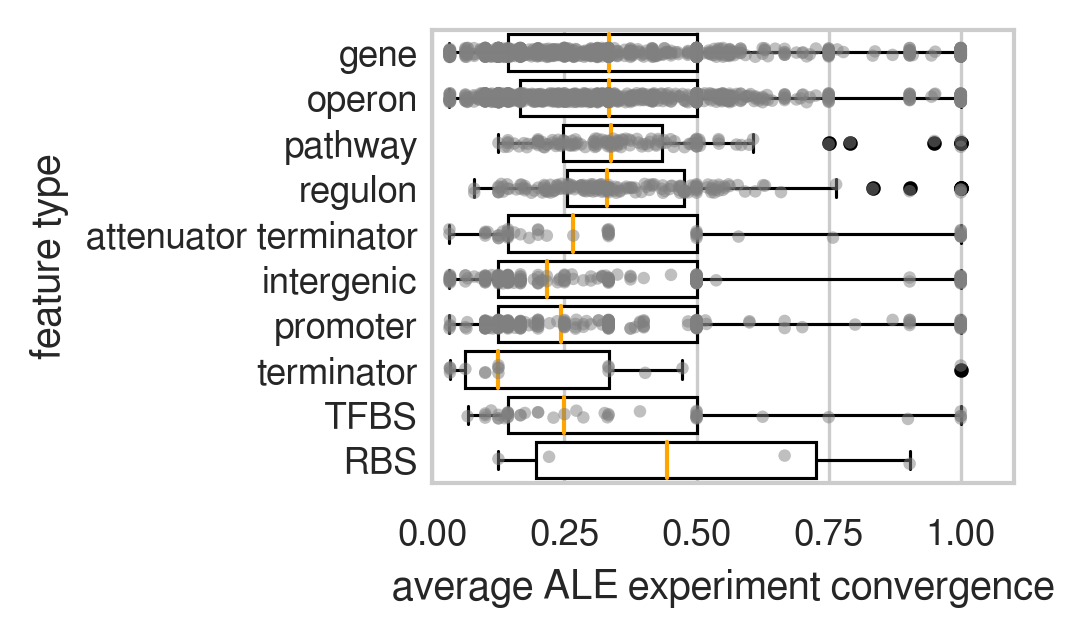

In [14]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from adjustText import adjust_text
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_palette("muted")
sns.set_context("paper")
# sns.set_style("ticks")
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ["FreeSans"]

boxplot_kwargs = {
    'boxprops': {'edgecolor': 'k', 'linewidth': 0.75},
    'whiskerprops': {'color': 'k', 'linewidth': 0.75},
    'medianprops': {'color': 'orange', 'linewidth': 1},
    'capprops': {'color': 'k', 'linewidth': 0.75},
    'flierprops': {'marker': '.', 'markerfacecolor': "black", 'markeredgecolor': "black"
#                    "markersize":1
                  }
}

plt.figure(figsize=(2.5, 2))
ax = sns.boxplot(data=mat, x="average ALE experiment convergence", y="feature type",
            color="white",
#                  order=["RBS", "TFBS", "promoter", "terminator", "attenuator terminator", "intergenic", "gene", "reaction", "operon", "pathway", "imodulon", "regulon"],
            **boxplot_kwargs
           )
sns.stripplot(data=mat, x="average ALE experiment convergence", y="feature type",
              color="0.5",
              alpha=0.5,
              size=3
#               facecolors=None
             )

ax.tick_params(axis='y', which='both', length=0)
ax.set_xlim(0,1.1)